## Building LeNet

In this exercise we want to build LeNet (LeCun et al., 1989), the first fully functional CNN for **classification**, in order to understand the syntax and the structure of a sequential CNN.

**0) Loading Libraries and Tools**

Importing Tensorflow/Keras libraries:

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.layers import Dense, Flatten, Conv2D, AveragePooling2D
from keras.utils  import to_categorical

<br>
Like in the discussion session, we want to analyse the MNIST data set, but this time, using a CNN. 

In [3]:
from keras.datasets import mnist

<br>
Finally, we also load the standard libraries for plotting and numeric operations.

In [5]:
import random 
import numpy as np
import matplotlib.pyplot as plt

<br>

**1) Loading the Data**

Let us examine the data first:

In [7]:
(Train_x, Train_y), (Test_x, Test_y) = mnist.load_data()

<br>
The dataset comprises $60\,000$ images for training and $10\,000$ images for testing. Each image is 28x28 pixel.

In [9]:
print(Train_x.shape)
print(Test_x.shape)

(60000, 28, 28)
(10000, 28, 28)


<br>
All images are 8bit encoded

In [11]:
print(np.max(Train_x[0,:,:]))

255


<br>
and are 2D matrices, hence gray scale images:

In [13]:
print(Train_x[0,:,:].shape)

(28, 28)


<br>
Of course, we would like to plot a few images:

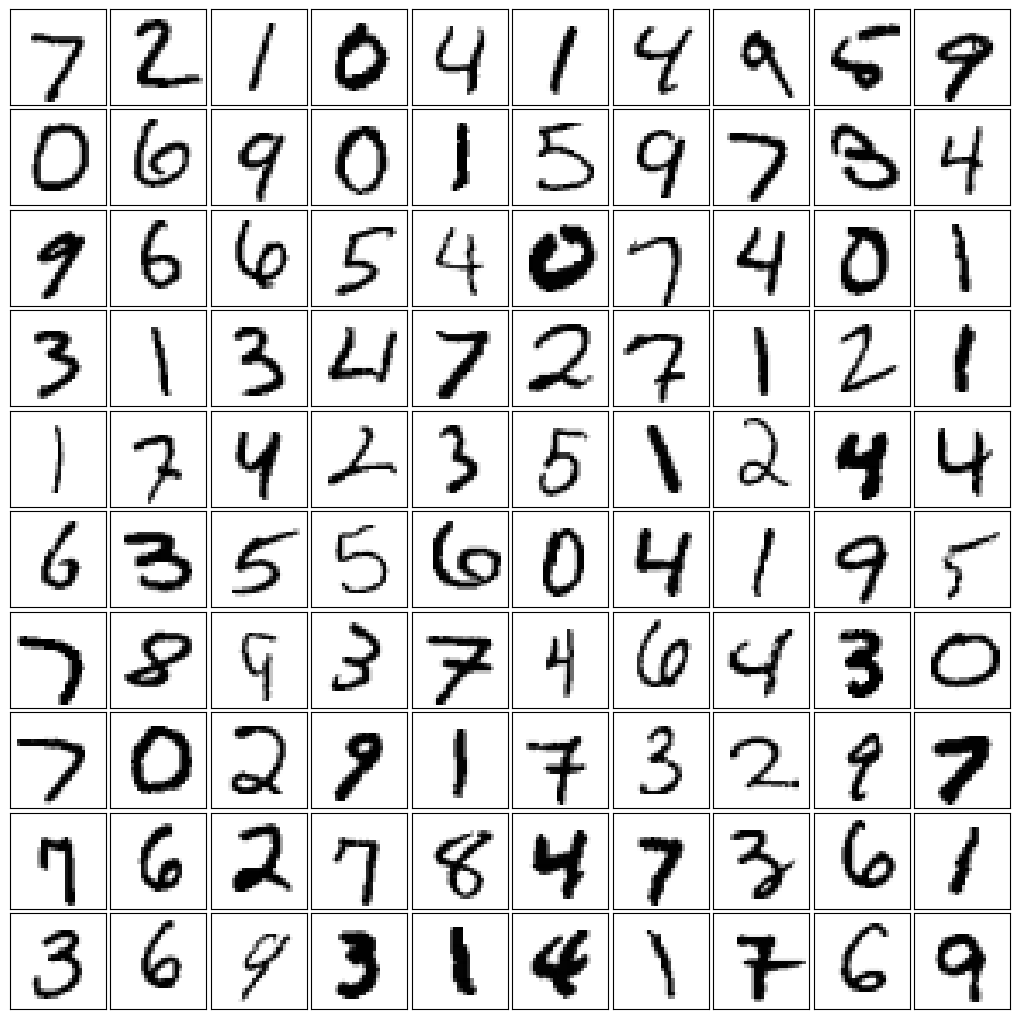

In [15]:
fig = plt.figure(figsize = (10, 10))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for i in range(100):
     ax = fig.add_subplot(10, 10, i + 1, xticks = [], yticks = [])
     ax.imshow(-Test_x[i,:,:] + np.max(Test_x[0,:,:]), cmap = 'gray', interpolation = 'nearest')

<br>
We also want to take a quick look at *Train_y*:

In [17]:
print(Train_y)

[5 0 4 ... 5 6 8]


<br>
In order to keep our coding clean and neat, we define *classes* for each step of our analysis, including loading and preprocessing the data. 

In [19]:
class CallData:
    
    def CallMNIST():
        
        ######################################################################################################################################################
        #loading and preparing training data
        (Train_x, Train_y), (Test_x, Test_y) = mnist.load_data()

        #adding new axis (to fit input shape required for ANN) and normalization (8 bit)
        Train_X3D = Train_x[:, :, :, np.newaxis]/255
        Test_X3D  = Test_x[:, :, :, np.newaxis]/255

        #y has to be turned in actual categorical, otherwise Python will prompt the error message:
        #    "Shapes (none, 1) and (none, 10) are incompatible categorical_crossentropy"

        num_classes = np.max(Test_y) + 1

        Train_y = to_categorical(Train_y, num_classes)
        Test_y  = to_categorical(Test_y, num_classes)

        #check
        Train_X3D.shape

        ######################################################################################################################################################
        #Splitting the training set into the actual training set and an evaluation set we want to process during the training in order to compare
        #training loss to evaluation loss.
        #note: the evaluation to training ratio can also be implemented when calling model.fit using the keyword validation_split = 0.2 etc
  
        N = len(Train_y)

        Train_X3D = np.array(Train_X3D)

        idx     = random.sample(range(N), round(N*0.2))
        val_x   = Train_X3D[idx, :, :, :]
        train_x = Train_X3D[[i for i in range(N) if i not in idx], :, :]
        val_y   = Train_y[idx]
        train_y = Train_y[[i for i in range(N) if i not in idx]]

        ######################################################################################################################################################

        return(num_classes, train_x, val_x, train_y, val_y, Test_X3D, Test_y)

<br>

**2) Building the Network**

Next, we want to generate a sequential CNN like LeNet. Most of the layers and keywords are familiar to us already.

In [21]:
class MyLeNet(Sequential):
    
    def __init__(self, input_shape, num_classes):
        super().__init__()

#building LeNet ##############################################################################################################################################
        #Note padding: string, either "valid" or "same" (case-insensitive). "valid" means no padding. "same" 
        #more info: https://keras.io/api/layers/convolution_layers/convolution2d/
        
        self.add(Conv2D(6,   kernel_size = (5, 5),    strides = (1, 1), activation = 'tanh', input_shape = input_shape, padding = 'same'))
        self.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2),                                                 padding = 'valid'))
        self.add(Conv2D(16,  kernel_size = (5, 5),    strides = (1, 1), activation = 'tanh',                            padding = 'valid'))
        self.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2),                                                 padding = 'valid'))
        self.add(Conv2D(120, kernel_size = (5, 5),    strides = (3, 3), activation = 'tanh',                            padding = 'valid'))
        self.add(Flatten())
        self.add(Dense(84,                                              activation = 'tanh'))
        self.add(Dense(num_classes,                                     activation = 'softmax'))
        ######################################################################################################################################################      

#building the optimizer ######################################################################################################################################
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-2, decay_steps = 10000, decay_rate = 0.98)
        opt         = tf.keras.optimizers.SGD(learning_rate = lr_schedule, momentum = 0.9)
            
        self.compile(optimizer = opt, loss = categorical_crossentropy, metrics = ['accuracy'])
        

<br>

**3) Training and Evaluation**

Finally, we want to run our network and evaluate the training. Also for that purpose, we define our own class.

In [23]:
class Model:

    def __init__(self):
        
        [self.num_classes, self.train_x, self.val_x, self.train_y, self.val_y, self.Test_X3D, self.Test_y] = CallData.CallMNIST()
        self.model                                                                                         = MyLeNet(self.train_x.shape[1:], self.num_classes)
        
        self.model.summary()
        
    def Run(self, epochs = 20, batch_size = 512):

        print('running model...')
        history = self.model.fit(self.train_x, self.train_y, epochs = epochs, batch_size = batch_size, validation_data = (self.val_x, self.val_y),\
                                 verbose = 1)

    #plotting ################################################################################################################################################
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc = 'upper left')
        plt.savefig('training results.pdf')
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc = 'upper left')
        plt.savefig('training loss.pdf')
        plt.show()
    ##########################################################################################################################################################

    def Eval(self):

        predict = self.model.predict(self.Test_X3D)

        fig = plt.figure(figsize = (7, 7))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

        
        N   = 49 #picking 49 images randomly
        idx = random.sample(range(self.Test_y.shape[0]), N)

        # plot the images: each image is 28x28 pixels
        for i in range(N):
            ii = idx[i]
            ax = fig.add_subplot(7, 7, i + 1, xticks = [], yticks = [])
            ax.imshow(self.Test_X3D[ii,:,:,0].reshape((28,28)), cmap = plt.cm.gray_r, interpolation = 'nearest')
            
            predclass = np.argmax(predict[ii,:])
            trueclass = np.argmax(self.Test_y[ii,:])
            
            S = str(predclass)
          
            if predclass == trueclass:
                P = str(round(predict[ii, predclass], 2))            #probability
                ax.text(0, 3, S + ', P = ' + P, color = [0, 1, 0.2])#label the image with the green text
            else:
                ax.text(0, 3, S + ', P = ' + P, color = [1, 0 , 0.2])              #label the image with the red text
                
        plt.savefig('evaluation results.pdf')
        plt.show()


<br>
Now, our package is ready to run:

In [25]:
#initialization
M = Model()

Model: "my_le_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0 

In [27]:
#running the model
M.Run()

running model...
Epoch 1/20
94/94 [==============================] - 8s 75ms/step - loss: 1.2109 - accuracy: 0.6723 - val_loss: 0.4686 - val_accuracy: 0.8652
Epoch 2/20
79/94 [========================>.....] - ETA: 0s - loss: 0.3890 - accuracy: 0.8905

KeyboardInterrupt: 

313/313 [==============================] - 2s 5ms/step


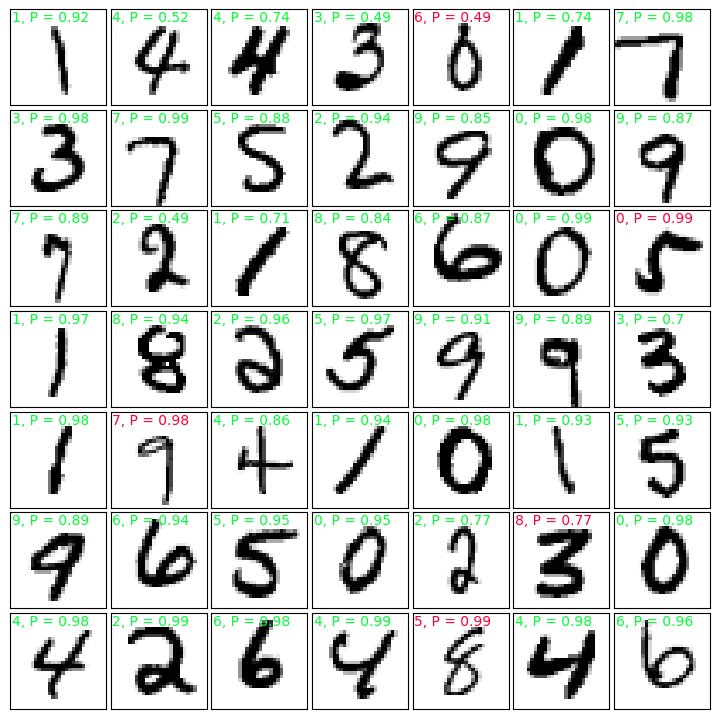

In [29]:
M.Eval()